# Wells

**Wells are one of the fundamental objects in `welly`.**

`Well` objects include collections of `Curve` objects. Multiple `Well` objects can be stored in a `Project`.

On this page, we take a closer look at the `Well`.

First, some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.5.3.dev6+g7fec7f4.d20220412'

## Load a well from LAS

In the Quick Start guide you saw how to quickly create a Project from a well with:

```python
import welly
project = welly.from_las('path/to/well.las')
```

A `welly.Project` is a collection of `welly.Well` objects. But if you only have a single well, you may not need a Project; a Well object on its own will do. Then you could do this:

```python
well, = welly.from_las('path/to/well.las')
```

The presence of the comma after `well` unpacks the single item into the `welly` variable. (This is a Python trick, it's not a Welly thing.)

Alternatively, you can use the `Well.from_las()` method to load a well by passing a filename as a `str`. This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [2]:
from welly import Well

p129 = Well.from_las('https://geocomp.s3.amazonaws.com/data/P-129.LAS')
p129

Only engine='normal' can read wrapped files


Well(uwi: 'Long = 63* 45'24.460  W', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

There are a lot of problems here:

- The Location is not stored correctly, with latitude stored in Location and Longitude stored in UWI (that's why it appears in the title row of this view).
- There's less accurate Lat and Lon information stored in Section and Township; we should get rid of those.
- There's no UWI, KB or TD, all of which would be useful to populate.

We can fix all this by 'remapping' some fields. This is done with a dictionary that maps a well's field to its location in the LAS file. For example, we can use the Well field ('Kennetcook #2') to as the UWI in our well with a mapping like: `{'UWI': 'WELL'}`. We can remove a bad item such as the Section name, by mapping to `None`:

In [17]:
remap = {
    'UWI': 'LIC',  # Commonly used unique name; not a true UWI.
    'KB': 'EKB',
    'TD': 'TDD',  # Driller's TD.
    'LATI': 'LOC',
    'LONG': 'UWI',
    'SECT': None,
    'TOWN': None,
    'LOC': None
}

p129 = Well.from_las('https://geocomp.s3.amazonaws.com/data/P-129.LAS', remap=remap)
p129

Only engine='normal' can read wrapped files


Well(uwi: 'P-129', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

That's better!

Later on, we'll look at how we can go a step further, extracting the more accurate 

## Well header

Metadata about the well is stored in its `header` attribute:

In [18]:
p129.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


### Important note

At present, the well's `header` contains a DataFrame with the entire LAS file header.

In a future release, only the well information from the **WELL** part of the file will be stored in the well's header. (The Params data goes into the `well.location` attribute, and the Curve data goes into Welly's `Curve` objects.)

## Well location

The well's `location` contains the location info from **PARAMS**, and will also store the well's 3D positional information, if available.

In [19]:
p129.location

Location({'position': None, 'crs': CRS({}), 'country': 'CA', 'province': 'Nova Scotia', 'latitude': 'Lat = 45* 12\' 34.237" N', 'longitude': "Long = 63* 45'24.460  W", 'datum': '', 'range': 'PD 176', 'ekb': 94.8, 'egl': 90.3, 'kb': 94.8, 'gl': 90.3, 'td': 1935.0, 'tdd': 1935.0, 'tdl': 1935.0, 'deviation': None})

The CRS for this well is missing; we can add one if we know it:

In [20]:
p129.location.crs = welly.CRS.from_epsg(2038)

p129.location

Location({'position': None, 'crs': CRS({'init': 'epsg:2038', 'no_defs': True}), 'country': 'CA', 'province': 'Nova Scotia', 'latitude': 'Lat = 45* 12\' 34.237" N', 'longitude': "Long = 63* 45'24.460  W", 'datum': '', 'range': 'PD 176', 'ekb': 94.8, 'egl': 90.3, 'kb': 94.8, 'gl': 90.3, 'td': 1935.0, 'tdd': 1935.0, 'tdl': 1935.0, 'deviation': None})

Right now there's no position log — we need to load a deviation survey.

In [21]:
p129.location.position

## Add deviation data to a well

Let's load another well:

In [1]:
import numpy as np
from welly import Well

p130 = Well.from_las('https://geocomp.s3.amazonaws.com/data/P-130.LAS')

dev = np.loadtxt('https://geocomp.s3.amazonaws.com/data/P-130_deviation_survey.csv',
                 delimiter=',', skiprows=1
                )

The columns are MD, inclination, azimuth, and TVD.

In [23]:
dev[:5]

array([[ 18. ,   0.3,   0. ,  18. ],
       [ 38. ,   0.5,   0. ,  38. ],
       [ 57. ,   1.5,   0. ,  57. ],
       [ 84. ,   1.8,   0. ,  84. ],
       [104. ,   0.5,   0. , 104. ]])

`add_deviation` wants only MD, inclination and azimuth, in that order. Given an array like that, it computes a position log.

In [25]:
p130.location.add_deviation(dev[:, :3], td=2618.3)

The columns in the position log are _x_ offset, _y_ offset, and TVD.

In [27]:
p130.location.position[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.71237821e-02, 1.79999178e+01],
       [0.00000000e+00, 1.86748917e-01, 3.79994202e+01],
       [0.00000000e+00, 5.18340431e-01, 5.69962853e+01],
       [0.00000000e+00, 1.29577626e+00, 8.39850594e+01]])

In [28]:
p130.location.trajectory()

array([[ 6.45933639e-01,  3.47023772e-01, -1.65395432e-02],
       [ 5.90396925e-01,  3.28218888e-01, -2.63643779e+00],
       [ 5.36457735e-01,  3.11968468e-01, -5.25632568e+00],
       ...,
       [-3.68094384e+00,  3.97484953e+01, -2.61112780e+03],
       [-3.68832058e+00,  3.96833189e+01, -2.61374906e+03],
       [-3.69619567e+00,  3.96172858e+01, -2.61637033e+03]])

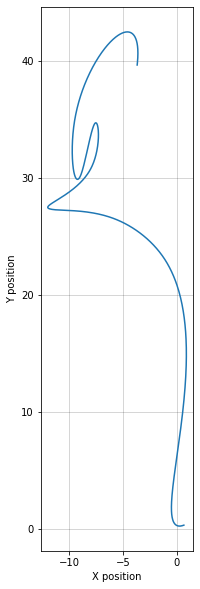

In [29]:
p130.location.plot_plan()

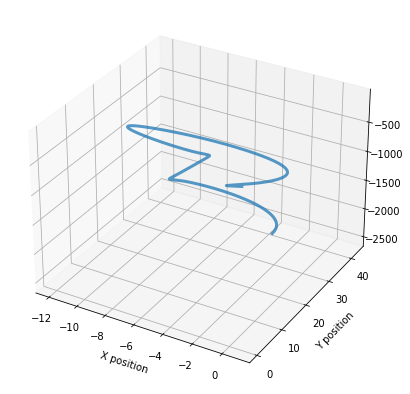

In [30]:
p130.location.plot_3d()

## Quick plot

`welly` produces `matplotlib` plots easily... but they aren't all that pretty. You can pass in an Axes object as `ax`, and you can embellish the plots by adding more `matplotlib` commands.

First, let's do the simplest thing possible:

In [ ]:
p130.plot()

Since we have a position log, it's worth plotting TVD as well (though it's almost the same as MD in this well).

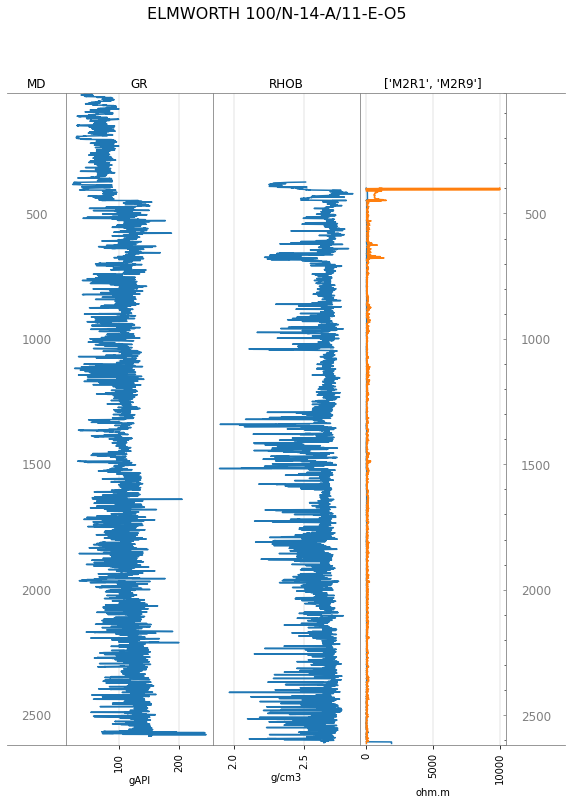

In [61]:
tracks = ['MD', 'GR', 'RHOB', ['M2R1', 'M2R9'], 'TVD']

p130.plot(tracks=tracks)

You can control the plotting style, but it requires a `striplog.Legend`. We find the easiest way to build one is with a CSV-like text string:

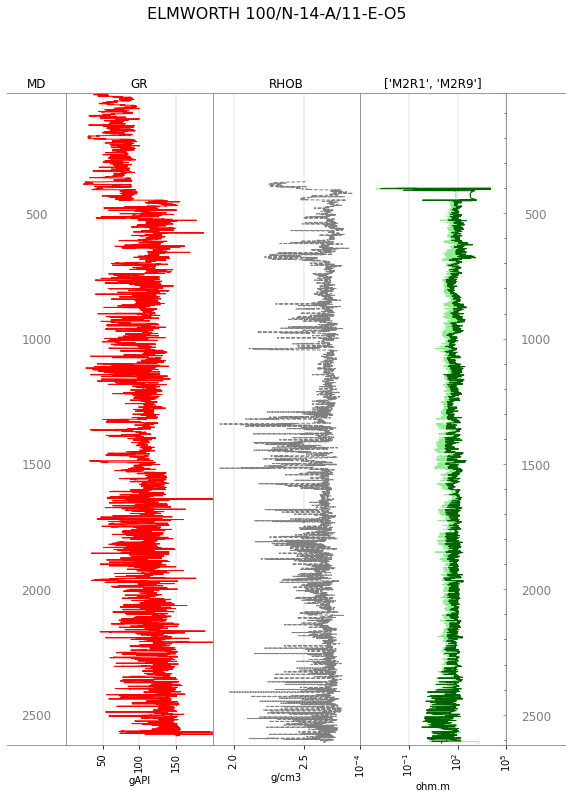

In [62]:
from striplog import Legend

curve_legend_csv = """curve mnemonic, colour,    lw,  ls,    xlim, xscale
                      GR,             #ff0000,   1.0,  -, "0,200", linear
                      RHOB,           gray,      1.0, --,        , linear
                      M2R9,           darkgreen, 1.0,  -,        , log
                      M2R1,           lightgreen,1.0,  -,        , log
"""
legend = Legend.from_csv(text=curve_legend_csv)

tracks = ['MD', 'GR', 'RHOB', ['M2R1', 'M2R9'], 'TVD']

p130.plot(tracks=tracks, legend=legend)

## Export curves to data matrix

Make a NumPy array out of the Curves in the well:

In [2]:
p130.data_as_matrix()

/home/matt/miniconda3/envs/welly/lib/python3.9/site-packages/welly/well.py:1094: UserWarning: In the next release, return_meta will be True by default. Set it to False to suppress this message. Set it to True to start using this feature now.
  warnings.warn(message)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

You can use aliases here, and it's helpful to know which curve is which. You can also start and stop at new depths, to cut out the NaNs:

In [21]:
alias = {'Gamma': ['GRC', 'GR', 'GRX'],
         'Density': ['RHOZ', 'RHOB'],
        }

X, depth, features = p130.data_as_matrix(keys=['Gamma', 'Density', 'DT'],
                                         alias=alias,
                                         start=1200, step=1,
                                         return_meta=True
                                        )

In [22]:
X.shape

(2624, 3)

In [23]:
depth

array([1200., 1201., 1202., ..., 3821., 3822., 3823.])

In [24]:
features

['Gamma', 'Density', 'DT']

## Export curves to pandas

You can always get the curve data as a DataFrame. The depth will be the index:

In [25]:
df = p130.df()

In [26]:
df.head()

,CALI,DT,NPHI_SAN,NPHI_LIM,NPHI_DOL,DPHI_LIM,DPHI_SAN,DPHI_DOL,M2R9,M2R6,M2R3,M2R2,M2R1,GR,SP,PEF,DRHO,RHOB
DEPT,,,,,,,,,,,,,,,,,,
20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='DEPT'>

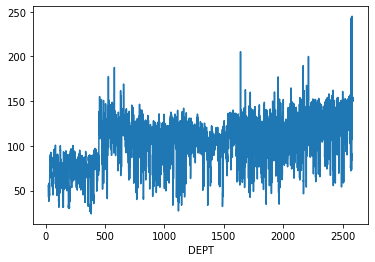

In [27]:
df.GR.plot()

To get the UWI of the well as well, e.g. if you want to combine multiple wells:

In [28]:
df = p130.df(uwi=True)

df.head()

CALI  DT  NPHI_SAN  NPHI_LIM  NPHI_DOL  DPHI_LIM  \
UWI            DEPT                                                     
100/N14A/11E05 20.1   NaN NaN       NaN       NaN       NaN       NaN   
               20.2   NaN NaN       NaN       NaN       NaN       NaN   
               20.3   NaN NaN       NaN       NaN       NaN       NaN   
               20.4   NaN NaN       NaN       NaN       NaN       NaN   
               20.5   NaN NaN       NaN       NaN       NaN       NaN   

                     DPHI_SAN  DPHI_DOL  M2R9  M2R6  M2R3  M2R2  M2R1  GR  SP  \
UWI            DEPT                                                             
100/N14A/11E05 20.1       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.2       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.3       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.4       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.5       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   

                     PEF  DRHO  RHOB  
UWI            DEPT                   
100/N14A/11E05 20.1  NaN   NaN   NaN  
               20.2  NaN   NaN   NaN  
               20.3  NaN   NaN   NaN  
               20.4  NaN   NaN   NaN  
               20.5  NaN   NaN   NaN

If you have several wells, you can also use `welly.Project.df()` to do the concatenation for you.

Note that you can also use aliases with the DataFrame creation, or create a new 'basis' (depth in this case):

In [34]:
keys = ['CALI', 'Gamma', 'Density']
df = p130.df(keys=keys, alias=alias, rename_aliased=True)
df.head()

,CALI,Gamma,Density
DEPT,,,
20.1,NaN,NaN,NaN
20.2,NaN,NaN,NaN
20.3,NaN,NaN,NaN
20.4,NaN,NaN,NaN
20.5,NaN,NaN,NaN


## Make an 'empty' well

In [36]:
import welly

w = welly.Well()

w.header  # is empty

,original_mnemonic,mnemonic,unit,value,descr,section


We can set the **UWI** and **name** of a well directly on the well object, but these are the only attributes of the well we can set in this way.

In [37]:
w.uwi = 'foo'
w.uwi

'foo'

In [38]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,UWI,UWI,None,foo,None,header


---

&copy; 2022 Agile Scientific, CC BY